##### feature set 5 chromosomes 2, 3, 4 

## In this notebook:
--> attempt to improve accuracy by incorporating predicted unk labels into model
* this model should be compared with exp 18. 
* this model has two extra step: after the model is fit in Pathogenic and Benign data:
    - 1. predict on unknown data, use the labels of the unknown data to append them to the initial df
    - 2. fit new model with the extra labeled data 

initial exp 18:
* single input dataframe 
* using feature set 5 (2+mutation counts)
* random forest

#### Highlights:
* Potentially questionable logic: use a model to predict label that you then use to predict more labels
* increased accuarcy a little from 86 --> 88

In [8]:
import torch
import pandas as pd
import numpy as np

# using sklearn goodies
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split


## pull in pickled dataframe:
df = pd.read_pickle("./pickled/chr2-4_featureset5.pkl")



print("shape before", df.shape)
df = df.replace({'.': 0})  ## FIXME: atm replace with nan and drop: later find a way to impute, maybe 0 but not sure
#print("SUM", pd.isnull(df).sum())  ## Use this to see how many elements have nan 
df = df.dropna()
print("shape after dropping all data with score = '.'", df.shape)
#print(df.head())

## still contains some mixed labels, see them by: df[~df['clinvar_clnsig'].isin(list(clinvar_labels.keys()))]

## Map labels to 1/0 and remove Unkn
clinvar_labels={
    'Pathogenic': 1,
    'Likely_pathogenic': 1,
    'Pathogenic/Likely_pathogenic': 1,
    'Benign/Likely_benign': 0,
    'Likely_benign': 0,
    'Benign': 0
}

#df.head()
#df = df[df['clinvar_clnsig'].isin(list(clinvar_labels.keys()))]  # best to drop everything that isn't in the dict
#df['Problematic'] = df['clinvar_clnsig'].map(clinvar_labels)

#df= df.drop(columns=['clinvar_clnsig'])#, 'clinvar_id'])  #tbh, I don't know why I kept them. consider adding to index

df = df.replace({'-': 0}) 
print("shape after dropping Unk", df.shape)
#df.head()
df_original = df.copy()

### pickle to reuse dataframe:
#df.to_pickle("./pickled_df/all_scores_chr18,20.pkl")


shape before (13820, 14)
shape after dropping all data with score = '.' (13820, 14)
shape after dropping Unk (13820, 14)


In [2]:
## Split into train/test
data_copy = df.copy()
df_train = data_copy.sample(frac=0.75, random_state=1)
df_test = data_copy.drop(df_train.index)

print ('Training data subset\n')
print (df_train.head(3))  # head default n=5, first 3 is enough
print ('\nTest data subset\n')
print (df_test.head(3))


## Get label:
train_labels = df_train.pop('Problematic')  # replace with clinvar when column is available
test_labels = df_test.pop('Problematic')

Training data subset

                       aapos codonpos  Polyphen2_HVAR_pred   GenoCanyon_score  \
chr pos       ref alt                                                           
2   222220292 G   A      341        1                    0  0.999999999414244   
4   95114733  T   C       53        1                   -2  0.999999997815507   
2   178694626 C   T    10150        1                    0  0.999728534038663   

                      LINSIGHT    RVIS_ExAC       ExAC_cnv.score  \
chr pos       ref alt                                              
2   222220292 G   A          0  0.126609025     1.41369465212203   
4   95114733  T   C          0  -0.03818213  -0.0678400328187906   
2   178694626 C   T          0  3.161811341                    0   

                       SORVA_LOF_MAF0.005_HetOrHom  Problematic  Mutation<1kb  \
chr pos       ref alt                                                           
2   222220292 G   A                       0.001198            1      

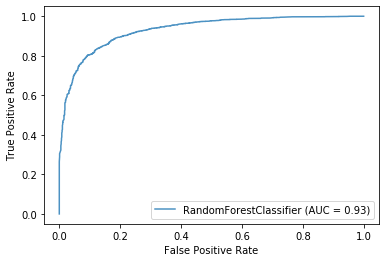

Confusion matrix: 
 [[ 710  266]
 [ 179 2258]]
Accuracy: 0.8696161734544389
Recall TP/(TP+FN): [0.72745902 0.92654904]
Precision TP/(TP+FP): [0.79865017 0.89461173]
F1: [0.7613941  0.91030034]
Feature ranking:
1. feature 2 (0.170793)
Polyphen2_HVAR_pred
2. feature 0 (0.157307)
aapos
3. feature 5 (0.101918)
RVIS_ExAC
4. feature 3 (0.093801)
GenoCanyon_score
5. feature 10 (0.064827)
Mutation<10kb
6. feature 11 (0.062792)
Mutation<30kb
7. feature 12 (0.062597)
Mutation<100kb
8. feature 8 (0.060262)
Mutation<1kb
9. feature 9 (0.057153)
Mutation<5kb
10. feature 6 (0.055441)
ExAC_cnv.score
11. feature 1 (0.053061)
codonpos
12. feature 7 (0.038329)
SORVA_LOF_MAF0.005_HetOrHom
13. feature 4 (0.021719)
LINSIGHT


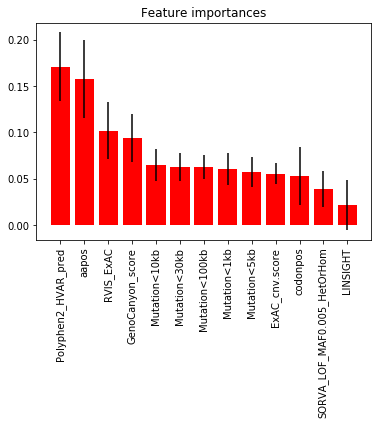

In [3]:
# Try a random forest:

forest = RandomForestClassifier(n_estimators=1000, random_state=42, class_weight="balanced")
forest.fit(df_train, train_labels)
ax = plt.gca()
rfc_disp = plot_roc_curve(forest, df_test, test_labels, ax=ax, alpha=0.8)
#svc_disp.plot(ax=ax, alpha=0.8) ## if you want to plot both svm and rf
plt.show()

## metrics:
y_true = test_labels.to_numpy()
y_pred = forest.predict(df_test)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
print("Confusion matrix: \n", confusion_matrix(y_true, y_pred))

# Accuracy
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_true, y_pred))

# Recall
from sklearn.metrics import recall_score
recall = recall_score(y_true, y_pred, average=None)
print("Recall TP/(TP+FN):", recall)

# Precision
from sklearn.metrics import precision_score
precision = precision_score(y_true, y_pred, average=None)
print("Precision TP/(TP+FP):",precision)


# F1 score
F1 = 2 * (precision * recall) / (precision + recall)
print("F1:", F1)

## Get at and plot the feature importance (tutorial: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)
feature_labels = list(df_train) # columns names
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")

for f in range(df_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    print(feature_labels[indices[f]])

    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(df_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(df_train.shape[1]), labels=df_train.columns[indices], rotation=90)
plt.xlim([-1, df_train.shape[1]])
plt.show()

### result of exp 11: n=10
Confusion matrix: 
 [[ 733  243]
 [ 251 2186]]
Accuracy: 0.855259302666276
Recall TP/(TP+FN): [0.75102459 0.89700451]
Precision TP/(TP+FP): [0.7449187  0.89995883]
F1: [0.74795918 0.89847924]
    
    
### result of exp 11: n=100
Confusion matrix: 
 [[ 687  289]
 [ 196 2241]]
Accuracy: 0.8578962789334896
Recall TP/(TP+FN): [0.70389344 0.91957325]
Precision TP/(TP+FP): [0.77802945 0.88577075]
F1: [0.73910705 0.90235555]


### result of exp 11: n=1000
Confusion matrix: 
 [[ 692  284]
 [ 191 2246]]
Accuracy: 0.8608262525637269
Recall TP/(TP+FN): [0.70901639 0.92162495]
Precision TP/(TP+FP): [0.78369196 0.88774704]
F1: [0.74448628 0.90436883]

### result of exp 11: n=1000 + balanced classes

Confusion matrix: 
 [[ 676  300]
 [ 182 2255]]
Accuracy: 0.8587752710225608
Recall TP/(TP+FN): [0.69262295 0.92531801]
Precision TP/(TP+FP): [0.78787879 0.88258317]
F1: [0.73718648 0.90344551]

In [4]:
## EXTRA! 1. predict on unknown data:
df_unk = pd.read_pickle("./pickled/chr1-4_featureset5_mutationcount.pkl")

#df= df.drop(columns=['clinvar_clnsig'])


print("shape before", df_unk.shape)
df_unk = df_unk.replace({'.': 0})  
df_unk = df_unk.dropna()
print("shape after dropping all data with score = '.'", df.shape)


df_unk = df_unk.replace({'-': 0}) 
print("shape after dropping Unk", df_unk.shape)
df_unk.head()

shape before (3988, 14)
shape after dropping all data with score = '.' (13820, 14)
shape after dropping Unk (3988, 14)


aapos codonpos  Polyphen2_HVAR_pred     GenoCanyon_score  \
chr pos    ref alt                                                             
1   65565  A   G        1        1                    0  2.01693589783425E-5   
    69453  G   C      121        3                    0  1.61590270936468E-5   
    69887  T   G      266        2                    0  4.18119972739408E-6   
    451053 C   G      209        2                    0                    0   
    451486 T   G       65        1                    0                    0   

                    LINSIGHT RVIS_ExAC ExAC_cnv.score  \
chr pos    ref alt                                      
1   65565  A   G    0.206807         0              0   
    69453  G   C           0         0              0   
    69887  T   G           0         0              0   
    451053 C   G           0         0              0   
    451486 T   G           0         0              0   

                    SORVA_LOF_MAF0.005_HetOrHom  Mutation<1kb  Mutation<5kb  \
chr pos    ref alt                                                            
1   65565  A   G                       0.000399             1             3   
    69453  G   C                       0.000399             2             3   
    69887  T   G                       0.000399             2             3   
    451053 C   G                       0.000000             2             2   
    451486 T   G                       0.000000             2             2   

                    Mutation<10kb  Mutation<30kb  Mutation<100kb  Problematic  
chr pos    ref alt                                                             
1   65565  A   G                3             11              15            1  
    69453  G   C                3             11              15            1  
    69887  T   G                3             11              15            0  
    451053 C   G                9              9              25            0  
    451486 T   G                9              9              25            0

In [9]:
## Concatenate original df with df_unk
df_all = df_original.copy()
labels = df_all.pop('Problematic') ## order of columns matters, set problematic to last
df_all['Problematic'] = labels

print("shape of df original", df.shape)
df_all = df_all.append(df_unk)
print("shape of df with unk", df_all.shape)

shape of df original (13820, 14)
shape of df with unk (17808, 14)


In [10]:
## Split into train/test
data_copy = df_all.copy()
df_train = data_copy.sample(frac=0.75, random_state=1)
df_test = data_copy.drop(df_train.index)

print ('Training data subset\n')
print (df_train.head(3))  # head default n=5, first 3 is enough
print ('\nTest data subset\n')
print (df_test.head(3))


## Get label:
train_labels = df_train.pop('Problematic')  # replace with clinvar when column is available
test_labels = df_test.pop('Problematic')

Training data subset

                      aapos codonpos  Polyphen2_HVAR_pred   GenoCanyon_score  \
chr pos      ref alt                                                           
2   47429943 T   C       -1        0                    0  0.999999997451172   
4   78266873 A   G      243        1                    0  0.999821200402614   
3   81648876 A   G      183        2                   -2  0.999999999611138   

                      LINSIGHT     RVIS_ExAC      ExAC_cnv.score  \
chr pos      ref alt                                               
2   47429943 T   C    0.855216  -1.024340829  -0.391627327762734   
4   78266873 A   G           0   4.065983717   -0.38579065416304   
3   81648876 A   G           0     0.7044008  -0.990328268432263   

                      SORVA_LOF_MAF0.005_HetOrHom  Mutation<1kb  Mutation<5kb  \
chr pos      ref alt                                                            
2   47429943 T   C                       0.000399            31           

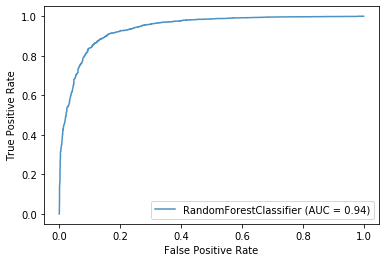

Confusion matrix: 
 [[1014  320]
 [ 191 2886]]
Accuracy: 0.8841532532305599
Recall TP/(TP+FN): [0.76011994 0.93792655]
Precision TP/(TP+FP): [0.84149378 0.90018715]
F1: [0.79873966 0.91866943]
Feature ranking:
1. feature 2 (0.248280)
Polyphen2_HVAR_pred
2. feature 0 (0.129133)
aapos
3. feature 5 (0.107129)
RVIS_ExAC
4. feature 3 (0.096539)
GenoCanyon_score
5. feature 12 (0.058083)
Mutation<100kb
6. feature 11 (0.056257)
Mutation<30kb
7. feature 10 (0.054446)
Mutation<10kb
8. feature 6 (0.052304)
ExAC_cnv.score
9. feature 8 (0.050164)
Mutation<1kb
10. feature 9 (0.047850)
Mutation<5kb
11. feature 1 (0.043882)
codonpos
12. feature 7 (0.034333)
SORVA_LOF_MAF0.005_HetOrHom
13. feature 4 (0.021600)
LINSIGHT


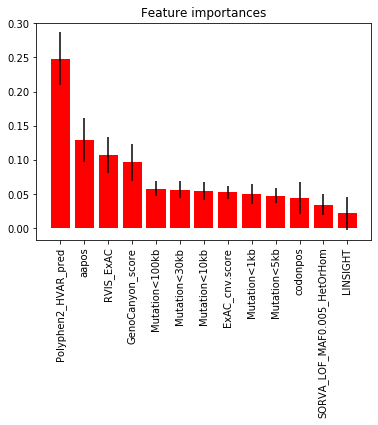

In [11]:
# RUN A RANDOM FOREST AGAIN (note, same code as above)

forest = RandomForestClassifier(n_estimators=1000, random_state=42, class_weight="balanced")
forest.fit(df_train, train_labels)
ax = plt.gca()
rfc_disp = plot_roc_curve(forest, df_test, test_labels, ax=ax, alpha=0.8)
#svc_disp.plot(ax=ax, alpha=0.8) ## if you want to plot both svm and rf
plt.show()

## metrics:
y_true = test_labels.to_numpy()
y_pred = forest.predict(df_test)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
print("Confusion matrix: \n", confusion_matrix(y_true, y_pred))

# Accuracy
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_true, y_pred))

# Recall
from sklearn.metrics import recall_score
recall = recall_score(y_true, y_pred, average=None)
print("Recall TP/(TP+FN):", recall)

# Precision
from sklearn.metrics import precision_score
precision = precision_score(y_true, y_pred, average=None)
print("Precision TP/(TP+FP):",precision)


# F1 score
F1 = 2 * (precision * recall) / (precision + recall)
print("F1:", F1)

## Get at and plot the feature importance (tutorial: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)
feature_labels = list(df_train) # columns names
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")

for f in range(df_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    print(feature_labels[indices[f]])

    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(df_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(df_train.shape[1]), labels=df_train.columns[indices], rotation=90)
plt.xlim([-1, df_train.shape[1]])
plt.show()